In [6]:
# Decision Tree
    # Greedy algorithm (we can change parameters & metrics (e.g. Gini/ Information Gain), but tree is deterministic)
    # Doesn't look for global maxima
    # Hyper-parameters: Gini cut-off value, Tree depth
    # Making tree more 'general' / reducing variance by pruning tree
# Bagging (Bootstrap Aggregation) - deep trees avg. over bootstrap samples
    # low bias due to deep trees (high-variance controlled by averaging)
    # Idea of bagging is a more general machine learning idea
# Random Forest - intent is to build more 'generalized' tree
    # At each node only M (=sqrt(P)) variables are used 
    # Decorrelates trees (similar idea to stochastic modeling) - information from all features is used
    # Hyper-parameters (unique to RF vs. DT)
        # Number of estimators - total trees to use in forest
        # Number of features - size of feature subset at each split
        # Bootstrap - sampling with replacement from training data for each sample
        # Out-of-Bag error - doesn't change the process; just calculate the metric or not
# Boosting (/ meta-learning) - 
    # Adaptive Boosting (AdaBoost) - ensemble of weak-learners (w/ 1 stump), diff. learning rate (alpha),
    #                                gradual learning with evolving 'weights'
    # Gradient Boosting - larger trees, same learning rate for all trees, gradual learning based on residuals
        
# Scikit learn implementation doesn't support categorical variables - https://scikit-learn.org/stable/modules/tree.html
# Gini impurity: lower = more class uniformity
    # Weighted Average Sum of Gini Impurity for each node; where Gini Impurrity for a node = 1-Sum(Pi^2)

# https://towardsdatascience.com/enchanted-random-forest-b08d418cb411#.hh7n1co54
# https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm

# OOB - probability of not selecting a particular point (total N points) in a sample (of size N)
    # = (n-1)^n/ n^n = ~36% for large n
    # = 67% probability for any particular point to be in a randomly selected sample w/ replacement

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier     #Random forest is under 'ensemble' not 'tree'
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV


import graphviz
from dtreeviz.trees import dtreeviz

## Example - Palmer Penguins dataset

In [6]:
# ![](https://imgur.com/orZWHly.png)

In [61]:
path = '../../GitHub/Python-Data-Science/Data/'
df = pd.read_csv(path+'penguins_size.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [62]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [63]:
df['species'].value_counts()

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

In [64]:
df.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [65]:
df[df.isnull().any(axis=1)]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN


In [66]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   culmen_length_mm   334 non-null    float64
 3   culmen_depth_mm    334 non-null    float64
 4   flipper_length_mm  334 non-null    float64
 5   body_mass_g        334 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


In [67]:
df.describe(include='all')

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,334,334,334.000000,334.000000,334.000000,334.000000,334
unique,3,3,NaN,NaN,NaN,NaN,3
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,MALE
freq,146,164,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.994311,17.160479,201.014970,4209.056886,NaN
std,NaN,NaN,5.460521,1.967909,14.022175,804.836129,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.500000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.500000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.575000,18.700000,213.000000,4793.750000,NaN


In [68]:
# Sex column shows 3 unique values?
df['sex'].value_counts()

MALE      168
FEMALE    165
.           1
Name: sex, dtype: int64

In [69]:
# Row with missing 'sex'
df[df['sex']=='.']

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


In [70]:
# Inconclusive
df[df['species']=='Gentoo'].groupby('sex').mean()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
sex,,,,
.,44.500000,15.700000,217.000000,4875.000000
FEMALE,45.563793,14.237931,212.706897,4679.741379
MALE,49.473770,15.718033,221.540984,5484.836066


In [1]:
df = df.drop(index=336)
df.info()

NameError: name 'df' is not defined

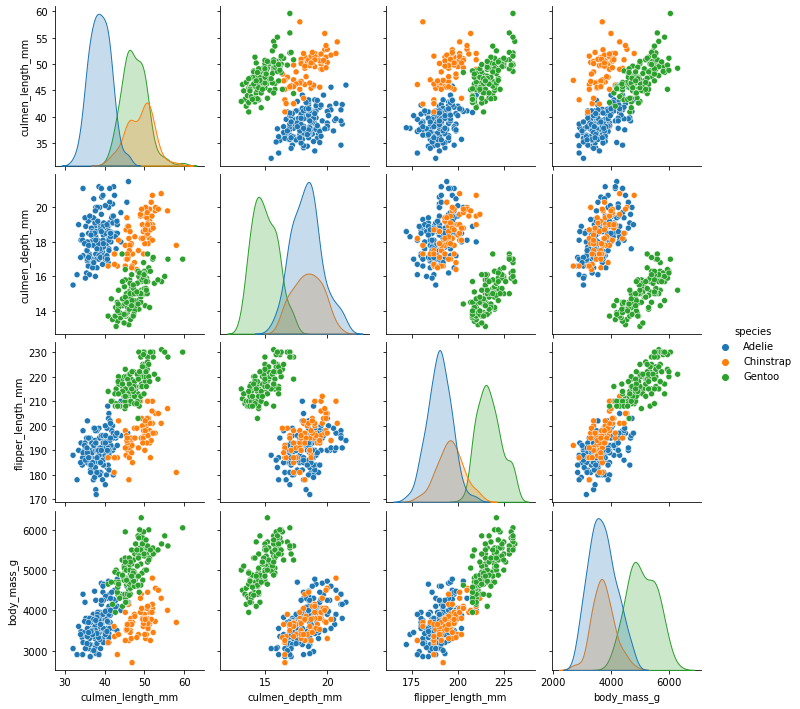

In [58]:
sns.pairplot(data=df, hue='species')

### Decision Tree Classifier - off-the-shelf

In [79]:
X = pd.get_dummies(df.drop(columns='species'), drop_first=True)
y = df['species']
display(X.head(), y.head())

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_MALE
0,39.1,18.7,181.0,3750.0,0,1,1
1,39.5,17.4,186.0,3800.0,0,1,0
2,40.3,18.0,195.0,3250.0,0,1,0
4,36.7,19.3,193.0,3450.0,0,1,0
5,39.3,20.6,190.0,3650.0,0,1,1


0    Adelie
1    Adelie
2    Adelie
4    Adelie
5    Adelie
Name: species, dtype: object

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [80]:
dc_model = DecisionTreeClassifier()

              precision    recall  f1-score   support

      Adelie       0.91      0.97      0.94        40
   Chinstrap       0.96      0.89      0.92        27
      Gentoo       1.00      0.97      0.98        33

    accuracy                           0.95       100
   macro avg       0.96      0.94      0.95       100
weighted avg       0.95      0.95      0.95       100



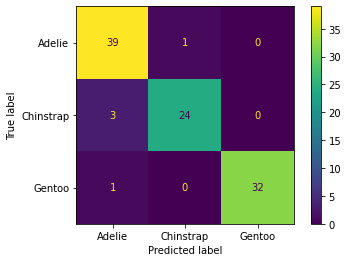

In [88]:
dc_model.fit(X_train, y_train)
y_pred = dc_model.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(dc_model, X_test, y_test)

### Decision Tree - model interpretation

In [101]:
pd.DataFrame(index = X.columns, data=dc_model.feature_importances_, columns=['Importance']).sort_values(by='Importance',
                                                                                                        ascending=False)

,Importance
flipper_length_mm,0.575758
culmen_length_mm,0.340359
island_Dream,0.038061
sex_MALE,0.025717
culmen_depth_mm,0.020106
body_mass_g,0.000000
island_Torgersen,0.000000


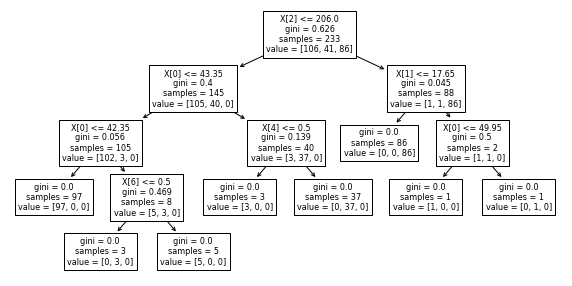

In [113]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10,5))
plot_tree(dc_model);

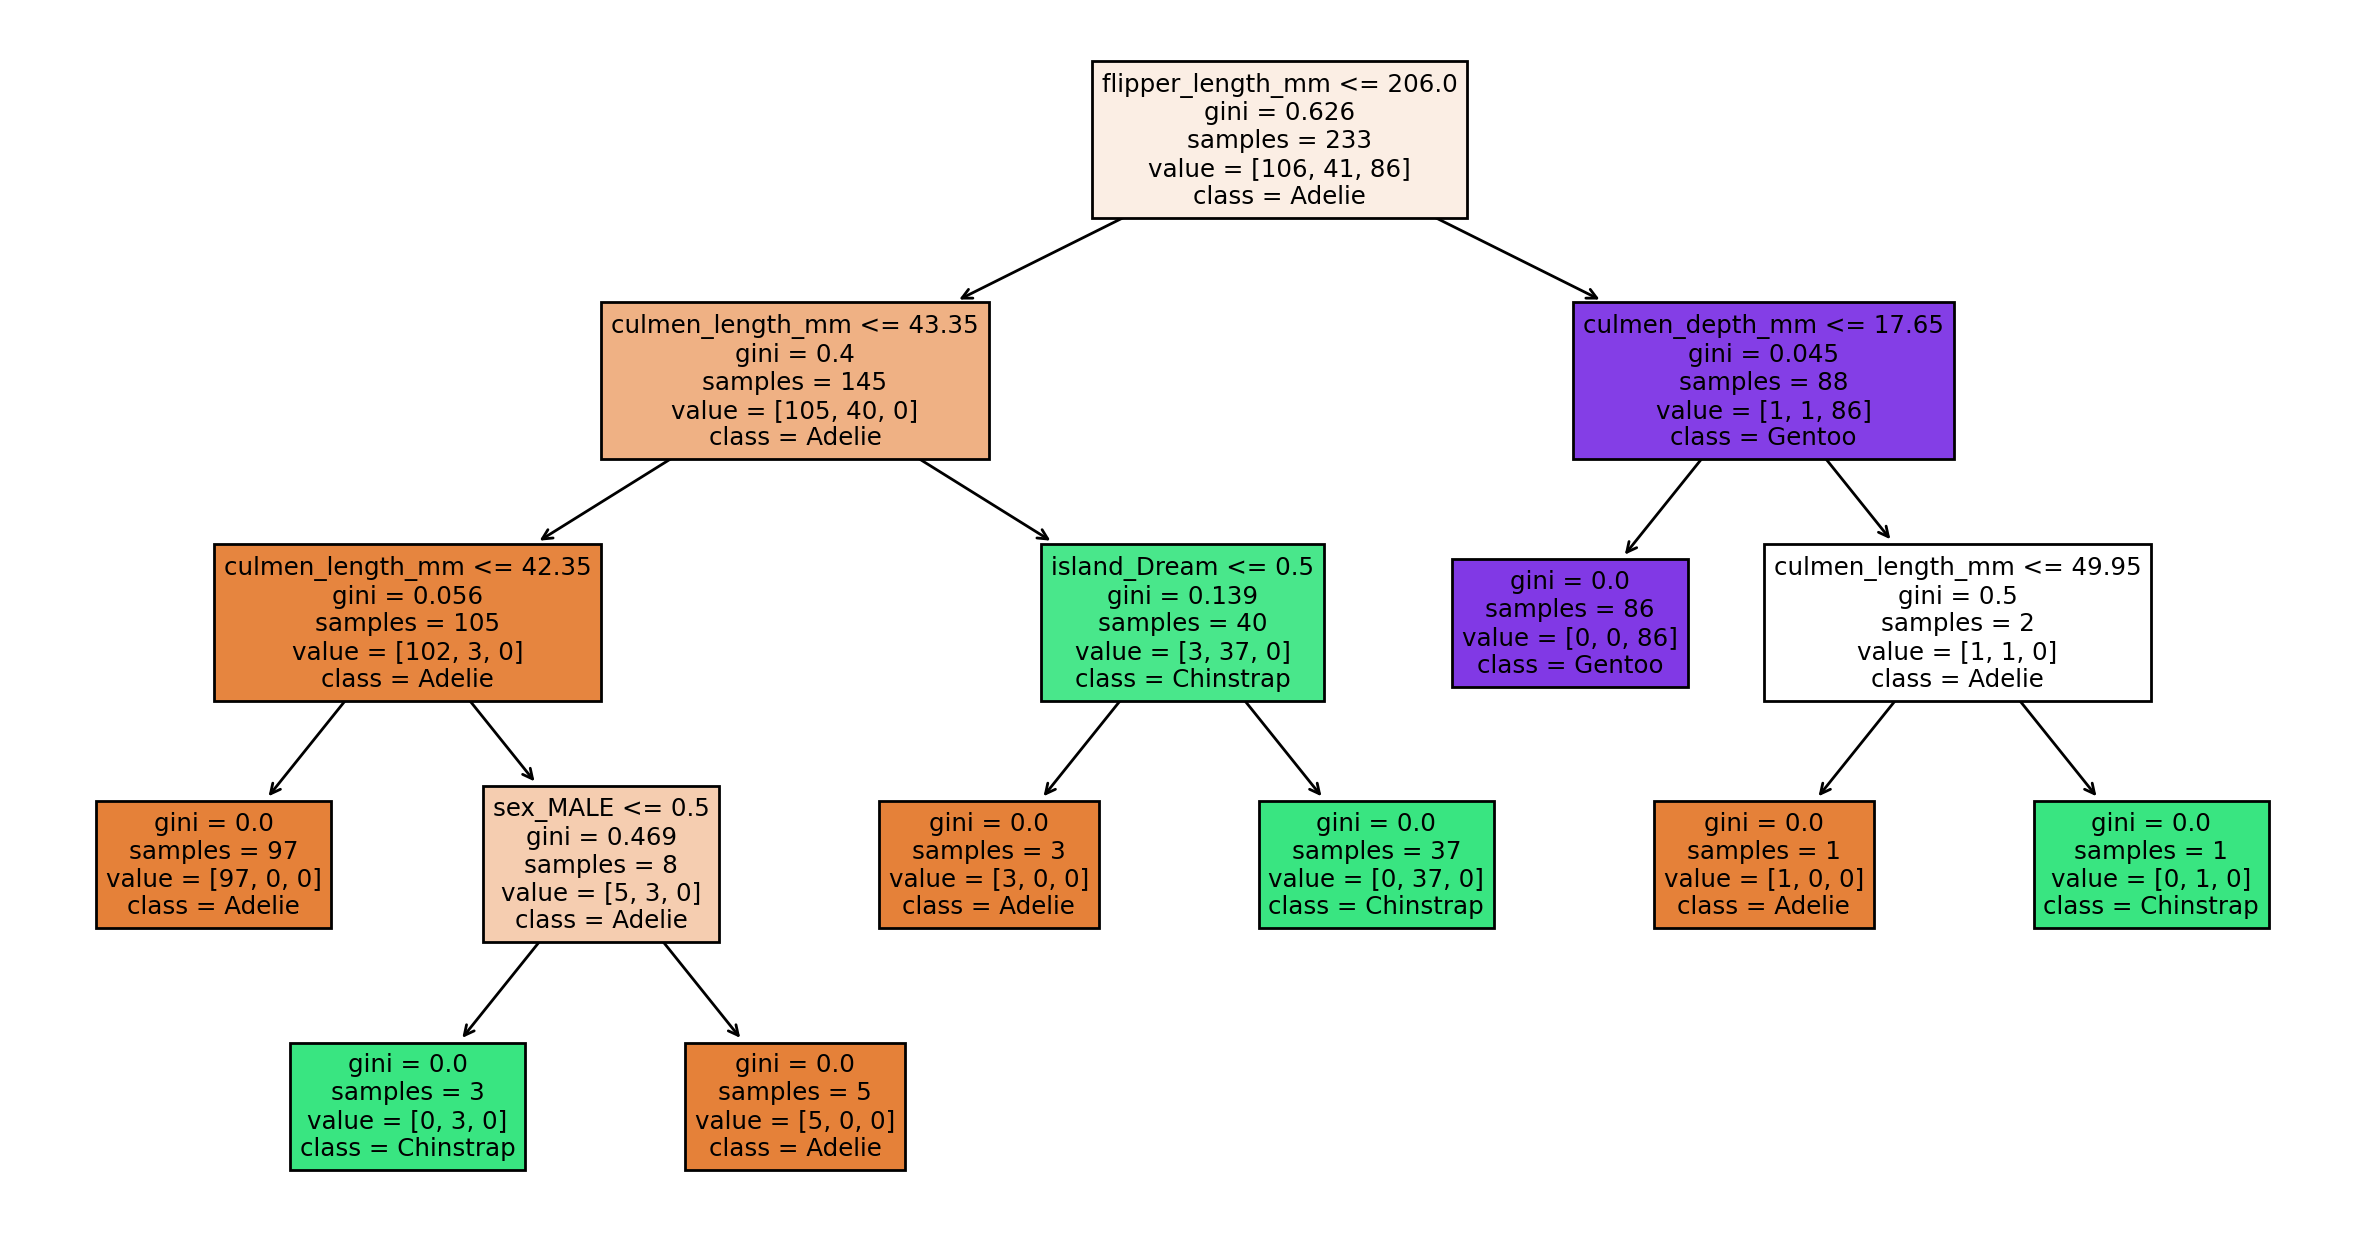

In [109]:
plt.figure(figsize=(15,8), dpi = 200)
plot_tree(dc_model, filled=True, feature_names=X.columns, class_names=['Adelie', 'Chinstrap', 'Gentoo']);

In [127]:
def report_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred), '\n')
    plt.figure(figsize=(15,8))
    plot_tree(model, filled=True, feature_names=X.columns, class_names=['Adelie', 'Chinstrap', 'Gentoo']);    

### Decision Tree - changing default parameters

In [128]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort='deprecated', ccp_alpha=0.0)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choos

[[39  1  0]
 [ 6 21  0]
 [ 0  1 32]] 



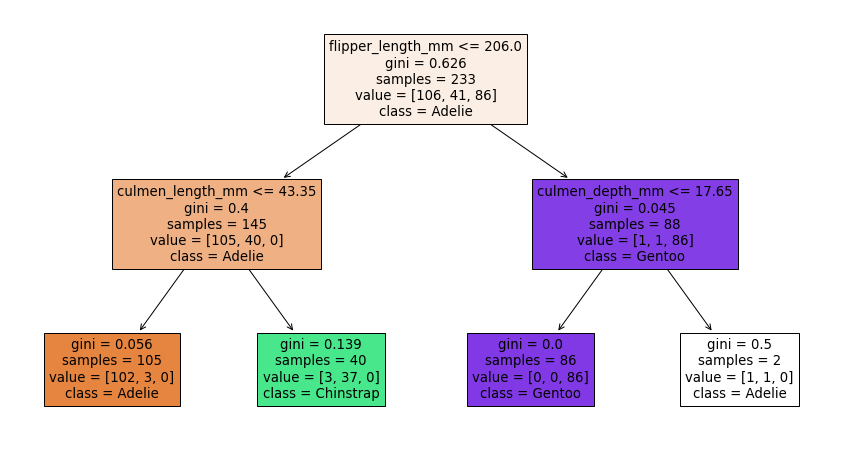

In [129]:
# max_depth : The maximum depth of the tree.
pruned_tree = DecisionTreeClassifier(max_depth=2)
report_model(pruned_tree)

[[39  1  0]
 [ 6 21  0]
 [ 1  0 32]] 



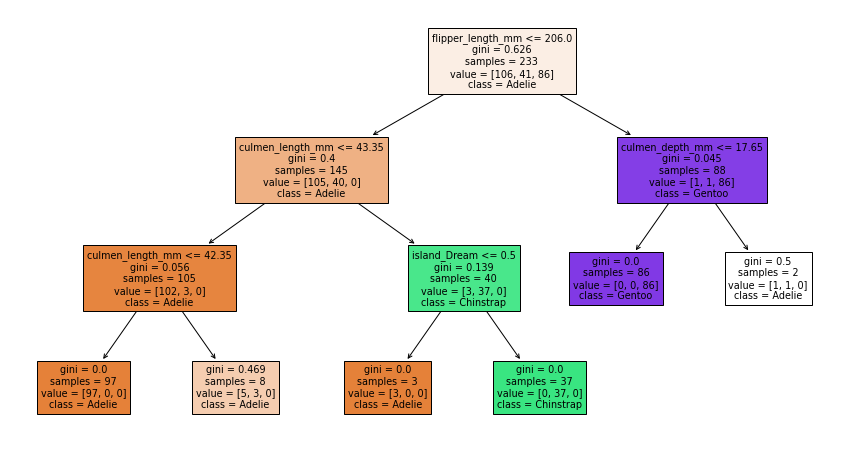

In [131]:
# min_samples_split : The minimum number of samples required to split an internal node
min_sample = DecisionTreeClassifier(min_samples_split=10)
report_model(min_sample)

[[38  1  1]
 [ 2 21  4]
 [ 0  1 32]] 



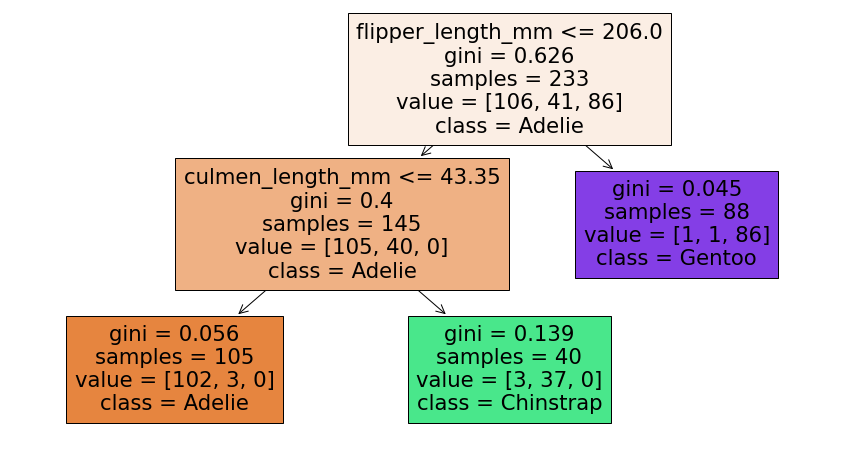

In [133]:
# max_leaf_nodes : Grow a tree with ``max_leaf_nodes`` in best-first fashion.
max_leaf = DecisionTreeClassifier(max_leaf_nodes=3)
report_model(max_leaf)

[[38  2  0]
 [ 1 26  0]
 [ 1  0 32]] 



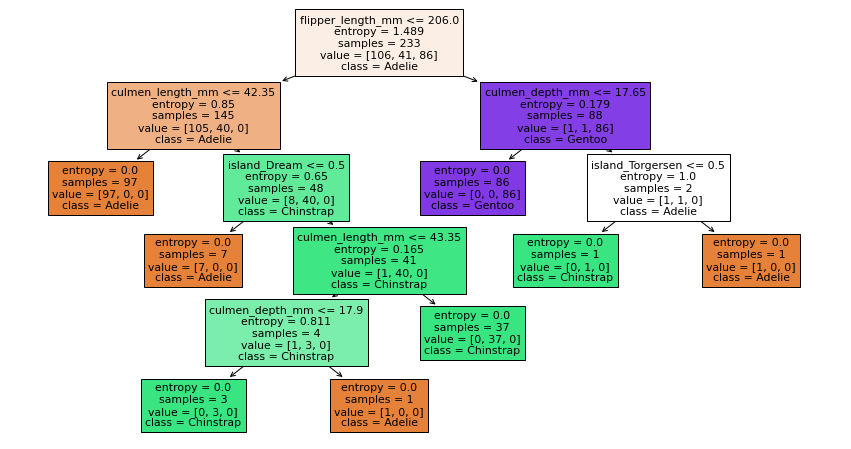

In [134]:
# criterion : {"gini", "entropy"}
entropy_model = DecisionTreeClassifier(criterion='entropy')
report_model(entropy_model)

### Random Forest

In [137]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[39  1  0]
 [ 1 26  0]
 [ 0  0 33]]


In [152]:
pd.DataFrame(index = X.columns, data=rf.feature_importances_, columns=['Importance'])\
.sort_values(by='Importance', ascending=False)

,Importance
culmen_length_mm,0.347627
flipper_length_mm,0.244621
culmen_depth_mm,0.140048
body_mass_g,0.122405
island_Dream,0.118939
island_Torgersen,0.021366
sex_MALE,0.004994


In [164]:
# Without Bootstrapping (by default 'bootstrap=True')
print(confusion_matrix(y_test, RandomForestClassifier(bootstrap=False).fit(X_train, y_train).predict(X_test)))

[[40  0  0]
 [ 1 26  0]
 [ 0  0 33]]


In [199]:
# Manually providing 'max_features'; sqrt(N) by default
print(confusion_matrix(y_test, RandomForestClassifier(max_features=3).fit(X_train, y_train).predict(X_test)))

[[39  1  0]
 [ 1 25  1]
 [ 1  0 32]]


In [207]:
# Changing number of trees
print(confusion_matrix(y_test, RandomForestClassifier(n_estimators=5).fit(X_train, y_train).predict(X_test)))

[[39  1  0]
 [ 1 25  1]
 [ 1  0 32]]


In [143]:
# Logistic gives good results in this case
# from sklearn.linear_model import LogisticRegression
# log = LogisticRegression(max_iter=10000)
# log.fit(X_train, y_train)
# print(confusion_matrix(y_test, log.predict(X_test)))

# [[39  1  0]
#  [ 0 27  0]
#  [ 0  0 33]]

[[39  1  0]
 [ 0 27  0]
 [ 0  0 33]]


In [148]:
# SVC works pretty well too with 'linear' kernel
# from sklearn.svm import SVC
# print(confusion_matrix(y_test, SVC(kernel='linear').fit(X_train, y_train).predict(X_test)))

# [[40  0  0]
#  [ 2 25  0]
#  [ 0  0 33]]

[[40  0  0]
 [ 2 25  0]
 [ 0  0 33]]


In [182]:
# Blending SVC, RF, Logistic
p1 = RandomForestClassifier(bootstrap=False).fit(X_train, y_train).predict(X_test)
p2 = LogisticRegression(max_iter=10000).fit(X_train, y_train).predict(X_test)
p3 = SVC(kernel='linear').fit(X_train, y_train).predict(X_test)

In [185]:
#Comparing mismatched o/p from different models
p = pd.DataFrame(dict(RF=p1, LOG=p2, SVC=p3, ACT=y_test))
p[(p['RF']!=p['LOG']) | (p['RF']!=p['SVC']) | (p['LOG']!=p['SVC'])]

,RF,LOG,SVC,ACT
37,Adelie,Chinstrap,Adelie,Adelie
199,Chinstrap,Chinstrap,Adelie,Chinstrap
182,Adelie,Chinstrap,Adelie,Chinstrap


---

## Example - Bank Note dataset
* https://archive.ics.uci.edu/ml/datasets/banknote+authentication

In [5]:
path = '../../GitHub/Python-Data-Science/Data/'
df = pd.read_csv(path+'data_banknote_authentication.csv')
df.info()
# Banknotes are scanned and a wavelet transformation is performed on those notes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Variance_Wavelet  1372 non-null   float64
 1   Skewness_Wavelet  1372 non-null   float64
 2   Curtosis_Wavelet  1372 non-null   float64
 3   Image_Entropy     1372 non-null   float64
 4   Class             1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [6]:
df.head()

,Variance_Wavelet,Skewness_Wavelet,Curtosis_Wavelet,Image_Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [8]:
df['Class'].value_counts()

0    762
1    610
Name: Class, dtype: int64

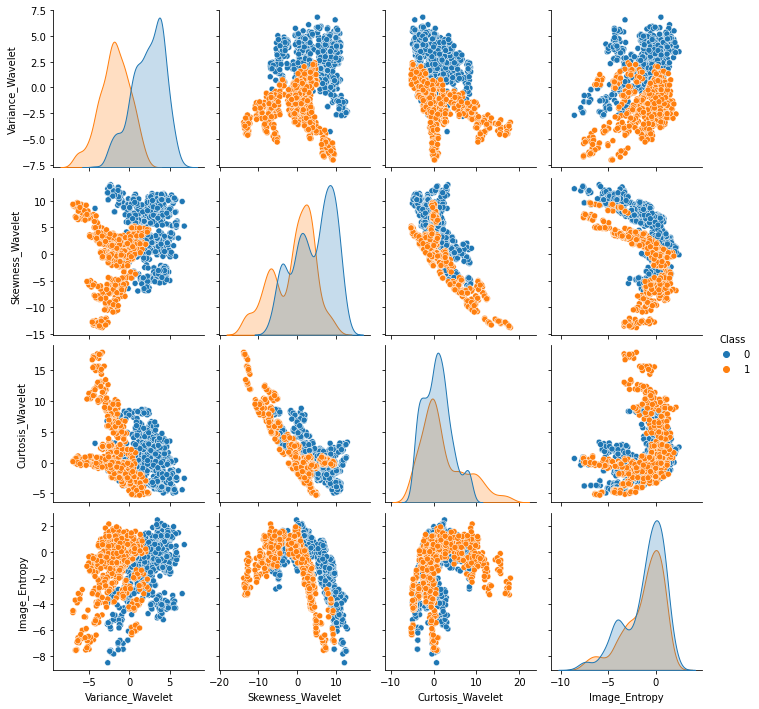

In [7]:
sns.pairplot(df, hue='Class')

In [12]:
X = df.drop(columns='Class')
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 101)

In [30]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print(confusion_matrix(y_test, rf.predict(X_test)))

[[122   2]
 [  0  82]]


In [ ]:
rf.oob_score_

In [23]:
param_grid = {'n_estimators':[50, 100, 150, 200],
              'criterion' : ['gini', 'entropy'],
              'max_features': [2, 3, 4],
              'bootstrap':['True', 'False']
             }

In [24]:
grid_model = GridSearchCV(rf, param_grid)
grid_model.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': ['True', 'False'],
                         'criterion': ['gini', 'entropy'],
                         'max_features': [2, 3, 4],
                         'n_estimators': [50, 100, 150, 200]})

In [25]:
grid_model.best_params_

{'bootstrap': 'False',
 'criterion': 'gini',
 'max_features': 2,
 'n_estimators': 200}

In [26]:
print(confusion_matrix(y_test, grid_model.predict(X_test)))

[[122   2]
 [  0  82]]


In [27]:
print(classification_report(y_test, grid_model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       124
           1       0.98      1.00      0.99        82

    accuracy                           0.99       206
   macro avg       0.99      0.99      0.99       206
weighted avg       0.99      0.99      0.99       206



In [39]:
error = []
misclass = []
for n in range(1,200):
    model = RandomForestClassifier(n_estimators=n)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    error.append(1-accuracy_score(y_test, y_pred))
    misclass.append(np.sum(y_pred != y_test))

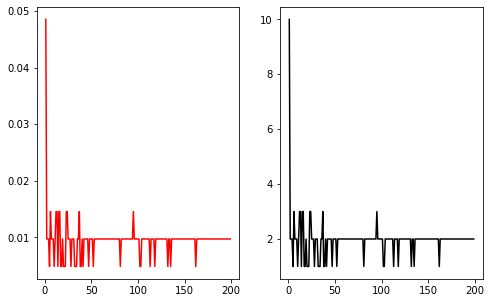

In [42]:
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.plot(range(1,200), error, color='red')

plt.subplot(1,2,2)
plt.plot(range(1,200), misclass, color='black')

---

## Example - Rock Density Xray dataset (regression)
* Compare a variety of models - Linear, Polynomial, KNN, Random Forest

In [46]:
path = '../../GitHub/Python-Data-Science/Data/'
df = pd.read_csv(path+'rock_density_xray.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Rebound Signal Strength nHz  300 non-null    float64
 1   Rock Density kg/m3           300 non-null    float64
dtypes: float64(2)
memory usage: 4.8 KB


In [47]:
df.head()

,Rebound Signal Strength nHz,Rock Density kg/m3
0,72.945124,2.456548
1,14.229877,2.601719
2,36.597334,1.967004
3,9.578899,2.300439
4,21.765897,2.452374


In [57]:
df.describe()

,Rebound Signal Strength nHz,Rock Density kg/m3
count,300.000000,300.000000
mean,49.725766,2.225063
std,28.341792,0.314512
min,0.700227,1.500000
25%,25.685798,1.987830
50%,50.602886,2.268597
75%,74.854294,2.476944
max,98.831658,2.750000


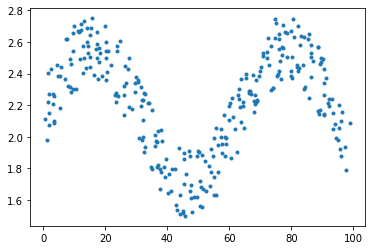

In [59]:
df.columns = ['signal', 'density']
plt.scatter(data=df, x='signal', y='density', marker='.')

In [165]:
X = df['signal'].values.reshape(-1, 1)
y = df['density']

In [191]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline                        #Note
from sklearn.metrics import mean_squared_error

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, random_state=101)
X_range = np.arange(-3,103).reshape(-1,1)

def run_model(model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print('RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, pred))), model)
    try:
        print('Best estimator: ', model.best_params_)
    except:
        pass
    plt.plot(X_range, model.predict(X_range), label=model)

RMSE: 0.2928 LinearRegression()
RMSE: 0.1450 Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('linearregression', LinearRegression())])
RMSE: 0.1300 GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1, 5, 10, 100, 1000],
                         'gamma': ['auto', 'scale']})
Best estimator:  {'C': 1000, 'gamma': 'scale'}
RMSE: 0.1404 RandomForestRegressor()
RMSE: 0.1388 KNeighborsRegressor(n_neighbors=8)


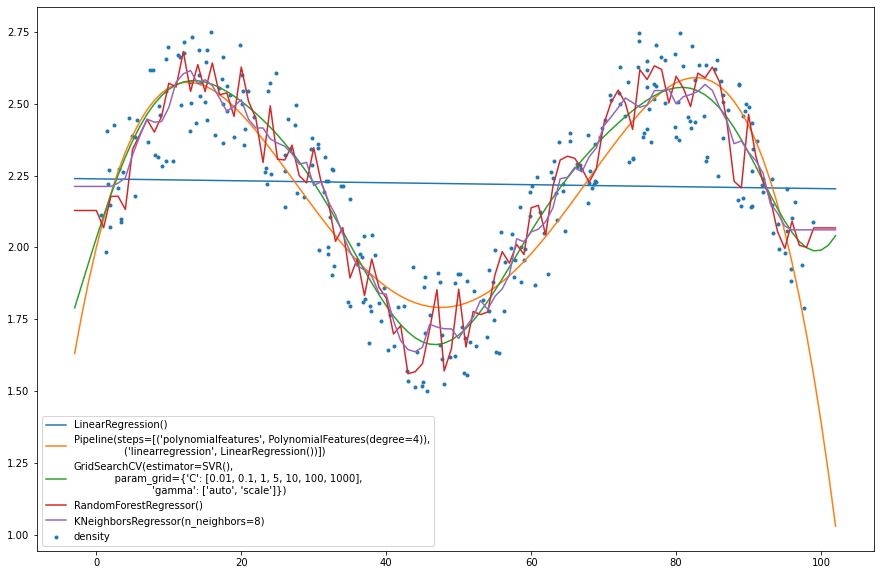

In [189]:
plt.figure(figsize=(15,10))
plt.scatter(data=df, x='signal', y='density', marker='.')

# Linear Regression - cannot model the curvature
lin = LinearRegression()
run_model(lin)

# Polynomial Regression - can approximate sinusoidal pattern with 'high' degrees, but poorly behaved at edges
pipe = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())
run_model(pipe)

# SVC - is best among the choices
svr = SVR()
param_grid = {'C':[0.01, 0.1, 1, 5, 10, 100, 1000],
              'gamma': ['auto', 'scale']}
grid = GridSearchCV(svr, param_grid)
run_model(grid)

# Random Forest - no smoothness/ continuity in output; constant at edges
rf = RandomForestRegressor()
run_model(rf)

# KNN - not smooth, but less jaggedy then RFR; constant at edges
knn = KNeighborsRegressor(n_neighbors=8)
run_model(knn)

plt.legend(loc='best')

RMSE: 0.1615 KNeighborsRegressor(n_neighbors=1)
RMSE: 0.1408 KNeighborsRegressor(n_neighbors=10)
RMSE: 0.1817 KNeighborsRegressor(n_neighbors=50)


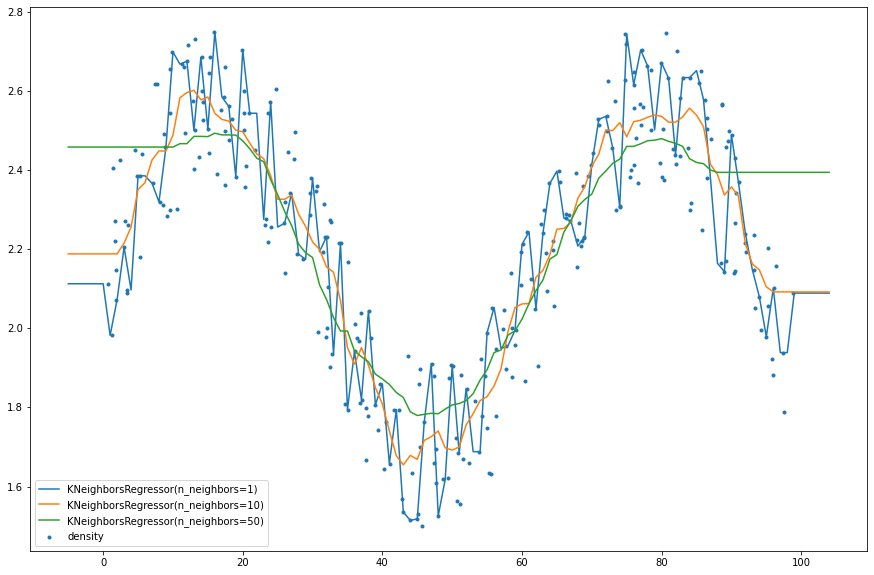

In [182]:
# KNN Regression for different values of 'k'
plt.figure(figsize=(15,10))
plt.scatter(data=df, x='signal', y='density', marker='.')

k_vals = [1, 10, 50]
for n in k_vals:
    knn = KNeighborsRegressor(n_neighbors=n)
    run_model(knn)
    
plt.legend(loc='best')

RMSE: 0.1334 GradientBoostingRegressor()
RMSE: 0.1309 AdaBoostRegressor()


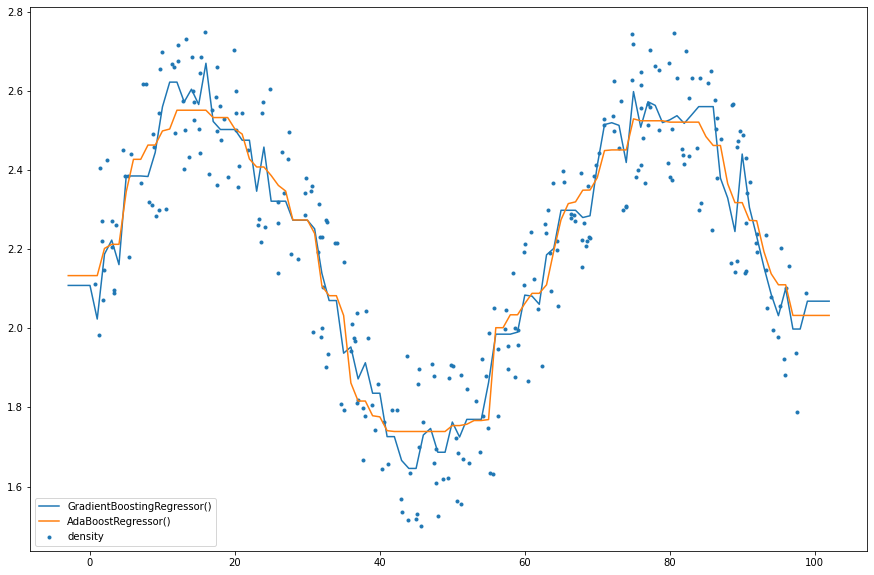

In [193]:
# Boosted Trees - perform marginally better than Random Forest in this case
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

plt.figure(figsize=(15,10))
plt.scatter(data=df, x='signal', y='density', marker='.')

gbr = GradientBoostingRegressor()
run_model(gbr)

ada = AdaBoostRegressor()
run_model(ada)

plt.legend(loc='best')

---

## Example - Mushroom dataset
* https://archive.ics.uci.edu/ml/datasets/mushroom

In [10]:
path = '../../GitHub/Python-Data-Science/Data/'
df = pd.read_csv(path+'mushrooms.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [13]:
df.iloc[0]

class                       p
cap-shape                   x
cap-surface                 s
cap-color                   n
bruises                     t
odor                        p
gill-attachment             f
gill-spacing                c
gill-size                   n
gill-color                  k
stalk-shape                 e
stalk-root                  e
stalk-surface-above-ring    s
stalk-surface-below-ring    s
stalk-color-above-ring      w
stalk-color-below-ring      w
veil-type                   p
veil-color                  w
ring-number                 o
ring-type                   p
spore-print-color           k
population                  s
habitat                     u
Name: 0, dtype: object

In [14]:
# Attribute Information:

# 1. cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
# 2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
# 3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
# 4. bruises?: bruises=t,no=f
# 5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
# 6. gill-attachment: attached=a,descending=d,free=f,notched=n
# 7. gill-spacing: close=c,crowded=w,distant=d
# 8. gill-size: broad=b,narrow=n
# 9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y
# 10. stalk-shape: enlarging=e,tapering=t
# 11. stalk-root: bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=?
# 12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
# 13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
# 14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
# 15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
# 16. veil-type: partial=p,universal=u
# 17. veil-color: brown=n,orange=o,white=w,yellow=y
# 18. ring-number: none=n,one=o,two=t
# 19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z
# 20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y
# 21. population: abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y
# 22. habitat: grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d

In [15]:
df['class'].value_counts()

e    4208
p    3916
Name: class, dtype: int64

In [19]:
df.describe().T.sort_values(by='unique')

,count,unique,top,freq
veil-type,8124,1,p,8124
class,8124,2,e,4208
bruises,8124,2,f,4748
gill-attachment,8124,2,f,7914
gill-spacing,8124,2,c,6812
gill-size,8124,2,b,5612
stalk-shape,8124,2,t,4608
ring-number,8124,3,o,7488
cap-surface,8124,4,y,3244
veil-color,8124,4,w,7924


In [22]:
X = df.drop(columns='class')
y = df['class'].copy()

In [23]:
X = pd.get_dummies(X, drop_first=True)
X.head(1)

,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_c,cap-color_e,...,population_n,population_s,population_v,population_y,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [26]:
ada = AdaBoostClassifier()            # By default - DecisionTreeClassifier(max_depth=1), 50 trees, learning rate = 1

In [28]:
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
print(confusion_matrix(y_test, y_pred))     # WOWZA 100% accuracy

[[1274    0]
 [   0 1164]]


In [35]:
pd.Series(index = X.columns, data = ada.feature_importances_).sort_values(ascending=False).head(10)

spore-print-color_w           0.18
gill-spacing_w                0.12
gill-size_n                   0.08
stalk-color-below-ring_n      0.08
population_c                  0.08
stalk-surface-above-ring_k    0.06
population_v                  0.06
odor_f                        0.04
odor_n                        0.04
odor_c                        0.04
dtype: float64

### Heuristics - identify most significant feature

In [36]:
# 1 tree with 1 stump
model = AdaBoostClassifier(n_estimators=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[1015  259]
 [  41 1123]]


In [38]:
# Best way to decide whether mushroom is poisonous or not, is to check whether the mushroom has odor or not
pd.Series(index = X.columns, data = model.feature_importances_).sort_values(ascending=False).head(5)

odor_n               1.0
gill-color_o         0.0
odor_y               0.0
gill-attachment_f    0.0
gill-spacing_w       0.0
dtype: float64

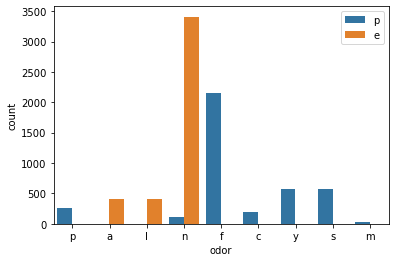

In [43]:
sns.countplot(data=df, x='odor', hue='class').legend(loc='upper right');

In [47]:
# error = []
# for i in range(1,len(X)):
#     model = AdaBoostClassifier(n_estimators=i)
#     model.fit(X_train, y_train)
#     pred = model.predict(X_test)
#     error.append(1-accuracy_score(y_test, pred))
# plt.plot(range(1,len(X)), error)

### Gradient Boosting

In [50]:
gba = GradientBoostingClassifier()
gba.fit(X_train, y_train)
y_pred = gba.predict(X_test)
print(confusion_matrix(y_test, y_pred))     # WOWZA 100% accuracy

[[1274    0]
 [   0 1164]]


In [51]:
pd.Series(index = X.columns, data = gba.feature_importances_).sort_values(ascending=False).head(10)

odor_n                        0.623855
stalk-root_c                  0.142297
bruises_t                     0.046572
stalk-surface-below-ring_y    0.040847
spore-print-color_r           0.029668
odor_l                        0.020427
stalk-root_r                  0.018704
gill-spacing_w                0.013864
odor_f                        0.012444
gill-size_n                   0.009785
dtype: float64

In [59]:
# with Gridsearch - suggests 50 trees vs. 100 (default)
gba = GradientBoostingClassifier()
param_grid = {'learning_rate':[0.1,0.05],
              'max_depth':[3,4,5],
              'max_features':[None, 'sqrt']}                 
    
grid = GridSearchCV(gba, param_grid)
grid.fit(X_train, y_train)
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'max_features': None}

In [60]:
print(confusion_matrix(y_test, grid.predict(X_test)))

[[1274    0]
 [   0 1164]]


In [61]:
gba = GradientBoostingClassifier(max_features='sqrt')
gba.fit(X_train, y_train)
print(confusion_matrix(y_test, gba.predict(X_test)))

[[1274    0]
 [   2 1162]]


---